# Decision Tree Classifier Algorithm

In this code, we will implement a decision tree algorithm from scratch. First we will define a data structure to represent the nodes. Then, we implement a function to find the best test for a node based on a cost function. We start from the root node and call the function recursively until we reach a max depth.

## Initialization

In [106]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

## Data Structure

We use a binary tree to assign inforation to the nodes.
* data indices: data indices which are in the region defined by that node
* split_feature: the feature used to split the node
* split_value: the value of the feature used to split the node
* left/right: the left and right nodes
* depth: depth of tree (used to stop recursion at some point)
* num_classes: the number of classes (C)
* data: the data (x)
* labels: the labels (y)
* class_prob: the probability of each class in the region

In [107]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None
        
        if parent:
            self.depth = parent.depth + 1
            self.num_classes = parent.num_classes
            self.data = parent.data
            self.labels = parent.labels
            
            # count the number of each class among the data indices of the region
            # ex: [23, 13, 14]
            # the class probability is each class count divided by total in region
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes)
            self.class_prob = class_prob / np.sum(class_prob)

## Cost Functions

* Misclassification Rate
* Entropy Cost
* Gini Index

In [108]:
def cost_misclassification(labels):
    '''Compute the highest error prediction rate of any class'''
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1- np.max(class_probs)

def cost_entropy(labels):
    '''Compute the entropy of the region.
       Expression for entropy -\sigma p(x)log[p(x)]'''
    class_probs = np.bincount(labels) / len(labels)
    # remove 0 probabilities
    class_probs = class_probs[class_probs > 0]
    return -np.sum(class_probs * np.log(class_probs))

def cost_gini_index(labels):
    '''Compute the Gini Index of the region.
       Expression for gini index 1-\sigma p(x)^2'''
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs)) 

## Greedy Splitting of a Node

We  consider all possible feature, value combinations for splitting the data of the node. The split that produces the lower cost is returned.

In [109]:
def greedy_test(node, cost_fn):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape

    # The test split values are the average of two consecutive sorted feature values.
    # ex: if our sorted data for one feature is [1,3,7,10] the test split values will be
    #     [2, 5, 8.5].

    # Sort the data by row
    # ex: [[23,4,10],   becomes  [[2,1,2],
    #      [2,45,7],              [23,4,7],
    #      [44,1,2]]              [44,45,10]]
    data_sorted = np.sort(node.data[node.data_indices], axis=0)

    # get in-between averages
    # ex: a = [1,2,3,4]
    # a[1:] --> [2,3,4]
    # a[:-1] --> [1,2,3]
    # test_candidates = [1.5, 2.5, 3.5]
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.

    # Test each feature
    for f in range(num_features):
        data_f = node.data[node.data_indices, f]
        # Test all test values per feature
        for test in test_candidates[:,f]:
            # split the data according to the test value
            # left indices = indices of the data where data_f < test
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]

            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            # compute the left and right cost
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])

            # compute the weighted total cost
            num_left = left_indices.shape[0]
            num_right = right_indices.shape[0]

            total_cost = (num_left * left_cost + num_right * right_cost) / num_instances

            if total_cost < best_cost:
                best_cost = total_cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value      

## Implement the Classifier

When to stop splitting:

* When there are not enough points under the current node (min_leaf_instances)
* When we reach the maximum depth (max_depth)
* If the decrease in the cost is negligible

In [110]:
class DecisionTree:
    def __init__(self, min_leaf_instances=1, max_depth=3, minimal_cost_decrease=0.05, cost_fn=cost_misclassification, num_classes=None):
        self.min_leaf_instances = min_leaf_instances         # minimal points under the current node
        self.max_depth = max_depth                           # max tree depth
        self.minimal_cost_decrease = minimal_cost_decrease   # minimal decrease in cost
        self.cost_fn = cost_fn                               # cost function to use
        self.num_classes = num_classes                       # number of classes
        self.root = None                                     # root of the decision tree
        
    def fit(self, data, labels):
        pass
    
    def predict(self, data_test):
        pass

## Fit

The fit is first called on the root node. The best test split is found and the method is called recursively on the left and right nodes until the max_depth or until the number of instances is lower than the minimum instances per leaf.


In [111]:
def fit(self, data, labels):
    ''' data: number of train instances x number of features
        labels: number of train instances x 1'''
    self.data = data
    self.labels = labels
    # INITIALIZE ROOT
    # initialize the number of classes for the root node
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
        
    #below are initialization of the root of the decision tree
    # data indices: [0,1,2,3,...,number of instances - 1]
    # parent: None
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    
    # STOP RECURSION
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    # GREEDY TEST
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    
    # print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

## Predict

For a new instance, we start at the root of the decision tree and we go down every feature until we reach a leaf node. The class probabilities of the leaf node are returned.

In [112]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    # n: index
    # x: data
    for n, x in enumerate(data_test):
        node = self.root
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

## Visualization

In [113]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,:2], dataset['target']
(num_instances, num_features), num_classes = x.shape, np.max(y)+1
inds = np.random.permutation(num_instances)
#train-test split)
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]

In [114]:
tree = DecisionTree(max_depth=20)
tree.fit(x_train, y_train)
# index of prediction corresponds to class number so we use argmax which
# returns index of largest value
y_pred = np.argmax(tree.predict(x_test), 1)
accuracy = np.sum(y_pred == y_test) / x_test.shape[0]
accuracy


0.64

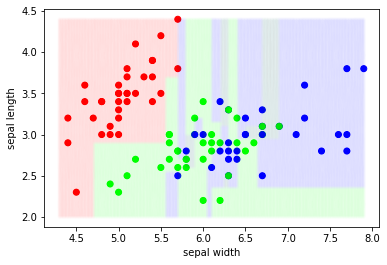

In [115]:
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=200)
y_train_prob = np.zeros((y_train.shape[0], num_classes))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
y_prob_all = model.fit(x_train, y_train).predict(x_all)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()